# Projet 7 - Elaborer un modele de scoring

## Modelisation - MLFlow

In [66]:
# %pip install hyperopt
# %pip install xgboost
# %pip install lightgbm
# %pip install lime
# %pip install shap
# %pip install -U evidently
# %pip install imblearn
# %pip install mlflow

In [67]:
import os
import shap
import time
import json
import random
import joblib
import datetime
import tempfile

from collections import Counter

import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path

from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_predict, cross_validate, cross_val_score, train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.impute import SimpleImputer
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import StandardScaler 

from sklearn.metrics import auc
from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, roc_auc_score, f1_score, accuracy_score, classification_report

from hyperopt.pyll.base import scope
from hyperopt import tpe, hp, fmin, space_eval, STATUS_OK, Trials, SparkTrials 

import xgboost as xgb
import lightgbm as ltb
from lightgbm import LGBMClassifier

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

from lime import lime_tabular

from evidently import Report
from evidently.presets import DataDriftPreset

import matplotlib.pyplot as plt

%matplotlib inline
sns.set_theme(palette="Set1")

### Chargement des dataset

In [68]:
data = pd.read_csv("../Sources/train_feature_engineering.csv", index_col=[0])
data_test = pd.read_csv("../Sources/test_feature_engineering.csv", index_col=[0])
data_full = pd.read_csv("../Sources/full_features_engineering.csv", index_col=[0])
data_inference = pd.read_csv("../Sources/inference_dataset.csv", index_col=[0])

In [69]:
# Inspect the problematic columns
problematic_columns = [
    "CC_NAME_CONTRACT_STATUS_Active_MIN",
    "CC_NAME_CONTRACT_STATUS_Active_MAX",
    "CC_NAME_CONTRACT_STATUS_Approved_MIN",
    "CC_NAME_CONTRACT_STATUS_Approved_MAX",
    "CC_NAME_CONTRACT_STATUS_Completed_MIN",
    "CC_NAME_CONTRACT_STATUS_Completed_MAX",
    "CC_NAME_CONTRACT_STATUS_Demand_MIN",
    "CC_NAME_CONTRACT_STATUS_Demand_MAX",
    "CC_NAME_CONTRACT_STATUS_Refused_MIN",
    "CC_NAME_CONTRACT_STATUS_Refused_MAX",
    "CC_NAME_CONTRACT_STATUS_Sent proposal_MIN",
    "CC_NAME_CONTRACT_STATUS_Sent proposal_MAX",
    "CC_NAME_CONTRACT_STATUS_Signed_MIN",
    "CC_NAME_CONTRACT_STATUS_Signed_MAX",
    "CC_NAME_CONTRACT_STATUS_nan_MIN",
    "CC_NAME_CONTRACT_STATUS_nan_MAX",
]

# Convert columns to numeric (if possible)
for col in problematic_columns:
    data[col] = pd.to_numeric(data[col], errors='coerce')
    data_test[col] = pd.to_numeric(data_test[col], errors='coerce')
    data_full[col] = pd.to_numeric(data_full[col], errors='coerce')
    data_inference[col] = pd.to_numeric(data_inference[col], errors='coerce')

# Check for any remaining non-numeric columns
non_numeric_columns = data.select_dtypes(include=['object']).columns
if len(non_numeric_columns) > 0:
    print("Remaining non-numeric columns:", non_numeric_columns)

In [70]:
# Rename columns to remove special characters
data.columns = data.columns.str.replace(r'[^\w]', '_', regex=True)
data_test.columns = data_test.columns.str.replace(r'[^\w]', '_', regex=True)
data_full.columns = data_full.columns.str.replace(r'[^\w]', '_', regex=True)
data_inference.columns = data_inference.columns.str.replace(r'[^\w]', '_', regex=True)

# Verify the updated column names
print("Updated column names:", data.columns)

Updated column names: Index(['NAME_CONTRACT_TYPE', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN',
       'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY',
       'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       ...
       'CC_NAME_CONTRACT_STATUS_Signed_MIN',
       'CC_NAME_CONTRACT_STATUS_Signed_MAX',
       'CC_NAME_CONTRACT_STATUS_Signed_MEAN',
       'CC_NAME_CONTRACT_STATUS_Signed_SUM',
       'CC_NAME_CONTRACT_STATUS_Signed_VAR', 'CC_NAME_CONTRACT_STATUS_nan_MIN',
       'CC_NAME_CONTRACT_STATUS_nan_MAX', 'CC_NAME_CONTRACT_STATUS_nan_MEAN',
       'CC_NAME_CONTRACT_STATUS_nan_SUM', 'CC_NAME_CONTRACT_STATUS_nan_VAR'],
      dtype='object', length=606)


In [71]:
data.dtypes.value_counts()

float64    437
bool       128
int64       41
Name: count, dtype: int64

In [72]:
data_test.dtypes.value_counts()

float64    436
bool       128
int64       41
Name: count, dtype: int64

In [73]:
data_full.dtypes.value_counts()

float64    438
bool       128
int64       41
Name: count, dtype: int64

In [74]:
data_inference.dtypes.value_counts()

float64    438
bool       128
int64       41
Name: count, dtype: int64

In [75]:
data_full.info()

<class 'pandas.core.frame.DataFrame'>
Index: 307511 entries, 0 to 307510
Columns: 607 entries, SK_ID_CURR to CC_NAME_CONTRACT_STATUS_nan_VAR
dtypes: bool(128), float64(438), int64(41)
memory usage: 1.1 GB


### Initialisation de plusieurs fonctions

In [76]:
def timeit(f):
    ''' 
    fonction décoratrice qui donne le temps d'éxecution d'une autre fonction
    '''
    def timed(*args, **kw):

        ts = time.time()
        result = f(*args, **kw)
        te = time.time()

        print (f"Durée d'exécution de {f.__name__}: {te-ts}s")
        return result

    return timed

In [77]:
# Function to display confusion matrix
def display_confusion_matrix(y_test, y_pred, model_name="Model"):
    
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
    plt.title(model_name + ": Confusion matrix")
    plt.grid(visible=None)
    plt.show()

In [78]:
# Function to compute roc curve
def compute_roc_curve(y_test, y_pred_proba, model_name="Model", disp_best_th=False):
    
    # Compute metrics
    fpr, tpr, thresholds = roc_curve(y_test,  y_pred_proba)
    auc = roc_auc_score(y_test, y_pred_proba)
    
    # Create fig
    plt.figure()
    plt.title(model_name + ": ROC curve")

    # Display x=y
    sns.lineplot(x=[0, 1], y=[0, 1], linestyle='--')

    # Display ROC curve
    sns.lineplot(x=fpr, y=tpr, legend='brief', label="AUC = {:.3f}".format((auc)))

    if disp_best_th is True:
        # Compute best threshold
        o_tpr = tpr[np.argmin(np.abs(fpr+tpr-1))]
        o_fpr = fpr[np.argmin(np.abs(fpr+tpr-1))]
        o_threshold = thresholds[np.argmin(np.abs(fpr+tpr-1))]

        # Display best threshold
        sns.scatterplot(x=[o_fpr], y=[o_tpr], legend='brief', label="Best threshold = {:.3f}".format(o_threshold))

    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc=4)
    plt.show()

    # Return AUC score
    return auc

In [79]:
# Return the best model from hyperopt trials
def trials_best_model(trials):
    
    valid_trial_list = [trial for trial in trials if STATUS_OK == trial['result']['status']]
    losses = [float(trial['result']['loss']) for trial in valid_trial_list]
    min_loss_idx = np.argmin(losses)
    best_trial_obj = valid_trial_list[min_loss_idx]
    print("Best result :", best_trial_obj['result']['loss'])
    return best_trial_obj['result']['model']

### Initialisation MLFlow

In [80]:
from mlflow import log_metrics, log_params, log_artifacts

In [81]:
import sys, mlflow
print("PYTHON =", sys.executable)
print("MLFLOW =", mlflow.__version__)

PYTHON = c:\Users\cosic\anaconda3\python.exe
MLFLOW = 3.3.2


In [82]:
#& "c:\Users\cosic\anaconda3\python.exe" -m mlflow server --host 127.0.0.1 --port 5000

In [83]:
# URI = "http://localhost:5000/"
# EXPERIMENT_NAME = "Credit_Scoring_Project"

# mlflow.set_tracking_uri(URI)
# EXPERIMENT_ID = mlflow.set_experiment(EXPERIMENT_NAME)

In [84]:
# Function to log model to mlflow
def log_mlflow(model, 
            name: str, 
            custom_score: float, 
            n_estimator: int | None = None, 
            max_depth: int | None = None, 
            auc_score: float | None = None, 
            f1_score: float | None = None, 
            acc_score: float | None = None,
            y_pred_proba=None,
            best_thresh: float | None = None,
            y_pred=None,
            train_class_0: int | float | None = None, 
            train_class_1: int | float | None = None,
            expected_features: list[str] | None = None,
            class_mapping: dict | None = None,
            tracking_uri: str | None = None,
            experiment_name: str | None = None,
            registered_model_name: str | None = None,
            X_sample=None):

    if tracking_uri:
        mlflow.set_tracking_uri(tracking_uri)
    if experiment_name:
        mlflow.set_experiment(experiment_name)

    # Track params and metrics 
    with mlflow.start_run(run_name=name) as run:

        # Set parameters
        params = {
            "n_estimators": n_estimator,
            "max_depth": max_depth,
            "train_class_0": train_class_0,
            "train_class_1": train_class_1
        }
        mlflow.log_params({k: v for k, v in params.items() if v is not None})

        # Set metrics only if not None
        metrics = {
            "Custom score": custom_score,
            "AUC": auc_score,
            "F1": f1_score,
            "Accuracy": acc_score,
            "Best Threshold": best_thresh
        }
        mlflow.log_metrics({k: v for k, v in metrics.items() if v is not None})

        # Save artifacts
        # Artifacts: sauvegarder les arrays y_pred_proba / y_pred
        with tempfile.TemporaryDirectory() as tmpdir:
            wrote_any = False
            if y_pred_proba is not None:
                np.save(os.path.join(tmpdir, "y_pred_proba.npy"), np.asarray(y_pred_proba))
                wrote_any = True
            if y_pred is not None:
                np.save(os.path.join(tmpdir, "y_pred.npy"), np.asarray(y_pred))
                wrote_any = True
            
            meta_payload = {
                "threshold": float(best_thresh) if best_thresh is not None else None,
                "expected_features": list(expected_features) if expected_features is not None else None,
                "class_mapping": class_mapping or None,
                "model_name": name,
            }
            meta_path = os.path.join(tmpdir, "meta.json")
            with open(meta_path, "w", encoding="utf-8") as f:
                json.dump(meta_payload, f, indent=2, ensure_ascii=False)
            wrote_any = True

            if wrote_any:
                mlflow.log_artifacts(tmpdir, artifact_path="artifacts")

        signature = None
        input_example = None
        try:
            if X_sample is not None:
                # probas de la classe 1
                proba_sample = model.predict_proba(X_sample)[:, 1]
                signature = infer_signature(X_sample, proba_sample)
                # garder un petit exemple
                try:
                    input_example = X_sample.iloc[:2]  # DataFrame
                except Exception:
                    # ndarray
                    input_example = np.asarray(X_sample)[:2]
        except Exception:
            # pas bloquant si la signature ne peut pas être inférée
            signature = None
            input_example = None

        # Log model
        artifact_path = "model"
        is_lgbm = getattr(model.__class__, "__module__", "").startswith("lightgbm")

        if is_lgbm:
            info = mlflow.lightgbm.log_model(
                lgb_model=model,
                artifact_path=artifact_path,
                signature=signature,
                input_example=input_example,
                registered_model_name=registered_model_name
            )
        else:
            info = mlflow.sklearn.log_model(
                sk_model=model,
                artifact_path=artifact_path,
                signature=signature,
                input_example=input_example,
                registered_model_name=registered_model_name
            )

        # run_id utile pour suivi
        return run.info.run_id, info.model_uri



## Data preparation

In [85]:
# Define target and features
TARGET = 'TARGET'
target_y = data[TARGET].to_numpy()
features_X = data.drop(columns=TARGET).to_numpy()
features_names = data.drop(columns=TARGET).columns.to_list()

# Define training set size
TRAIN_SIZE = 0.2

# Define random state
RANDOM_STATE = 42

### Valeurs manquantes

In [86]:
# Check missing values
nan_values = data.isna().sum().sum()
print("Missing values = {} ({:.2%})".format(nan_values, nan_values/data.size))

Missing values = 37539669 (20.14%)


#### Les valeurs manquantes peuvent etre traites directement par les modeles.
#### Dans un premier temps je vais gerer les valeurs manquantes et on fera une seconde methode plus tard.

In [87]:
# Create imputer
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')

# Fit to data
imp_mean.fit(features_X)

# Transform data
features_fill = imp_mean.transform(features_X)

### Split data

#### Decoupage en training et testing

In [88]:
# Split dataset (filled)
x_train, x_test, y_train, y_test = train_test_split(features_fill, target_y, train_size=TRAIN_SIZE, random_state=RANDOM_STATE)

In [89]:
# Define stratifiedKfold
strat_kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

## Balanced data

In [90]:
y_train_counter = Counter(y_train)
print("Training target statistics:", y_train_counter)
print("Testing target statistics:", Counter(y_test))

# Print ratio
print("Ratio is 1:{:.0f}".format(y_train_counter[0] / y_train_counter[1]))

Training target statistics: Counter({0.0: 56549, 1.0: 4953})
Testing target statistics: Counter({0.0: 226137, 1.0: 19872})
Ratio is 1:11


#### Je vais définir un pipeline qui transforme d'abord l'ensemble de données d'entraînement avec SMOTE, puis ajuste le modèle

In [91]:
# Define oversampling and undersampling
over = SMOTE(sampling_strategy=0.5) # oversample to 1:2 ratio 
under = RandomUnderSampler(sampling_strategy=1) # undersample to 1:1 ratio

# Define pipeline
steps = [('over', over), ('under', under)]
pipeline = Pipeline(steps=steps)

# Transform the dataset
x_res, y_res = pipeline.fit_resample(x_train, y_train)

print("Training target statistics:", Counter(y_res))
print("Testing target statistics:", Counter(y_test))

Training target statistics: Counter({0.0: 28274, 1.0: 28274})
Testing target statistics: Counter({0.0: 226137, 1.0: 19872})


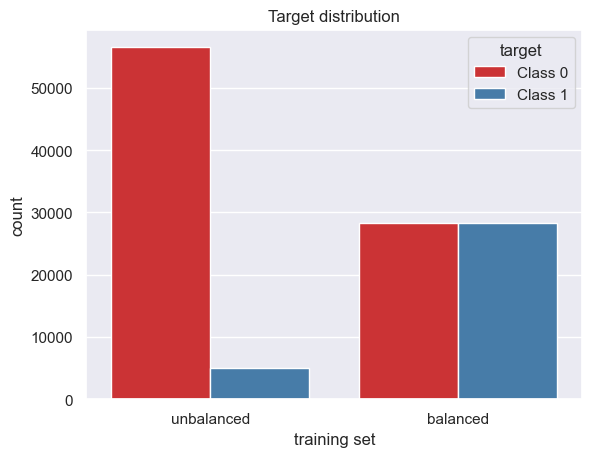

In [92]:
# Display barplot of distribution
class_distr_df = pd.DataFrame({'training set': ['unbalanced', 'unbalanced', 'balanced', 'balanced'],
                               'target': ['Class 0', 'Class 1', 'Class 0', 'Class 1'],
                               'count': [y_train_counter[0], y_train_counter[1], Counter(y_res)[0], Counter(y_res)[1]]})

# Display barplot
sns.barplot(class_distr_df, x='training set', y='count', hue='target')
plt.title("Target distribution")
plt.show()

## Elaboration du modele

* Le déséquilibre entre le nombre de bons et de moins bons clients doit être pris en compte pour élaborer un modèle pertinent, avec une méthode au choix
* Le déséquilibre du coût métier entre un faux négatif (FN - mauvais client prédit bon client : donc crédit accordé et perte en capital) et un faux positif (FP - bon client prédit mauvais : donc refus crédit et manque à gagner en marge)
* Vous pourrez supposer, par exemple, que le coût d’un FN est dix fois supérieur au coût d’un FP
* Vous créerez un score “métier” (minimisation du coût d’erreur de prédiction des FN et FP) pour comparer les modèles, afin de choisir le meilleur modèle et ses meilleurs hyperparamètres. Attention cette minimisation du coût métier doit passer par l’optimisation du seuil qui détermine, à partir d’une probabilité, la classe 0 ou 1 (un “predict” suppose un seuil à 0.5 qui n’est pas forcément l’optimum)
* En parallèle, maintenez pour comparaison et contrôle des mesures plus techniques, telles que l’AUC et l’accuracy 

## Utilisation des donnees sans le SMOTE et laisser la gestion des valeurs manquantes par le modele directement.

In [93]:
@timeit
def echantillonage(df_X, df_y):
    X = df_X.copy()
    y = df_y.copy()
    
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=TRAIN_SIZE, random_state=RANDOM_STATE)
    
    return X_train, X_valid, y_train, y_valid

In [94]:
# Split dataset
x_train, x_test, y_train, y_test = echantillonage(features_X, target_y)

# Define stratifiedKfold
strat_kf = StratifiedKFold(n_splits=2, shuffle=True, random_state=RANDOM_STATE)

Durée d'exécution de echantillonage: 5.1877124309539795s


In [95]:
y_train_counter = Counter(y_train)
print("Training target statistics:", y_train_counter)
print("Testing target statistics:", Counter(y_test))

# Print ratio
print("Ratio is 1:{:.0f}".format(y_train_counter[0] / y_train_counter[1]))

Training target statistics: Counter({0.0: 226132, 1.0: 19876})
Testing target statistics: Counter({0.0: 56554, 1.0: 4949})
Ratio is 1:11


### Creation d'un echantillon pour les divers tests d'algo sinon ca coute trop de temps/ressources

In [96]:
sample_X = data.drop(columns=TARGET).sample(n= 50000)
sample_y = data[TARGET][sample_X.index]

train_sample_set, val_sample_set, train_sample_labels, val_sample_labels = echantillonage(sample_X,sample_y)

Durée d'exécution de echantillonage: 0.22733139991760254s


In [97]:
display(train_sample_set.shape)
display(val_sample_set.shape)

(40000, 605)

(10000, 605)

In [98]:
train_sample_set[TARGET]=train_sample_labels
val_sample_set[TARGET]=val_sample_labels

In [99]:
display(train_sample_set.shape)
display(val_sample_set.shape)

(40000, 606)

(10000, 606)

In [100]:
train_sample_set = train_sample_set.reset_index()
val_sample_set = val_sample_set.reset_index()

In [101]:
display(train_sample_set.shape)
display(val_sample_set.shape)

(40000, 607)

(10000, 607)

In [102]:
train_sample_set.drop(columns = ['index'], inplace=True)
val_sample_set.drop(columns = ['index'], inplace=True)

In [103]:
display(train_sample_set.shape)
display(val_sample_set.shape)

(40000, 606)

(10000, 606)

In [104]:
print('train shape :',x_train.shape)
print('validation shape :',x_test.shape)


print('train sample shape :',train_sample_set.shape)
print('validation sample shape :',val_sample_set.shape)

train shape : (246008, 605)
validation shape : (61503, 605)
train sample shape : (40000, 606)
validation sample shape : (10000, 606)


In [105]:
full_X = data.drop(columns=TARGET)
full_y = data[TARGET]

train_full_set, val_full_set, train_full_labels, val_full_labels = echantillonage(full_X, full_y)

Durée d'exécution de echantillonage: 1.4448590278625488s


In [106]:
data_inference.drop(columns = TARGET, inplace=True)

In [107]:
print('train full shape :',train_full_set.shape)
print('validation full shape :',val_full_set.shape)
print('data full shape :',data_full.shape)
print('data inference shape :',data_inference.shape)

train full shape : (246008, 605)
validation full shape : (61503, 605)
data full shape : (307511, 607)
data inference shape : (356255, 606)


In [108]:
train_full_set

,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,CC_NAME_CONTRACT_STATUS_Signed_MIN,CC_NAME_CONTRACT_STATUS_Signed_MAX,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_NAME_CONTRACT_STATUS_nan_MIN,CC_NAME_CONTRACT_STATUS_nan_MAX,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_NAME_CONTRACT_STATUS_nan_SUM,CC_NAME_CONTRACT_STATUS_nan_VAR
123473,0,1,0,0,171000.0,555273.0,16366.5,0.035792,-23349,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10118,0,0,1,1,157500.0,198085.5,23638.5,0.010032,-10921,-117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
64716,0,1,1,0,135000.0,776304.0,25173.0,0.035792,-23213,-2157.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
234940,0,1,1,1,164133.0,900000.0,36787.5,0.030755,-10703,-2530.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
236051,0,0,1,0,225000.0,533668.5,21294.0,0.025164,-15798,-3520.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119879,0,0,1,0,121500.0,675000.0,32602.5,0.006305,-14481,-1124.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
259178,0,0,0,2,225000.0,509922.0,40419.0,0.003069,-15492,-292.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
131932,0,1,1,0,450000.0,1125000.0,33025.5,0.014520,-14309,-5929.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
146867,1,1,1,1,180000.0,270000.0,13500.0,0.010006,-12706,-1868.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [109]:
data_inference

,SK_ID_CURR,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,REGION_POPULATION_RELATIVE,DAYS_BIRTH,...,CC_NAME_CONTRACT_STATUS_Signed_MIN,CC_NAME_CONTRACT_STATUS_Signed_MAX,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_NAME_CONTRACT_STATUS_nan_MIN,CC_NAME_CONTRACT_STATUS_nan_MAX,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_NAME_CONTRACT_STATUS_nan_SUM,CC_NAME_CONTRACT_STATUS_nan_VAR
0,100002.0,0,0,1,0,202500.0,406597.5,24700.5,0.018801,-9461,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,100003.0,0,0,0,0,270000.0,1293502.5,35698.5,0.003541,-16765,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,100004.0,1,1,1,0,67500.0,135000.0,6750.0,0.010032,-19046,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,100006.0,0,0,1,0,135000.0,312682.5,29686.5,0.008019,-19005,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,100007.0,0,0,1,0,121500.0,513000.0,21865.5,0.028663,-19932,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
356250,456221.0,0,0,1,0,121500.0,412560.0,17473.5,0.002042,-19970,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
356251,456222.0,0,0,0,2,157500.0,622413.0,31909.5,0.035792,-11186,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
356252,456223.0,0,1,1,1,202500.0,315000.0,33205.5,0.026392,-15922,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
356253,456224.0,0,0,0,0,225000.0,450000.0,25128.0,0.018850,-13968,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [110]:
ART = Path("artifacts")
meta = json.loads((ART / "artifacts.json").read_text(encoding="utf-8"))
EXPECTED = meta["expected_features"]

df_inf = data_inference.copy()

cols = ["SK_ID_CURR"] + EXPECTED
df_save = df_inf[cols].copy()

df_save["SK_ID_CURR"] = df_save["SK_ID_CURR"].astype(str).str.strip()

df_save.to_parquet("features.parquet", index=False)

In [111]:
df_save.info()

<class 'pandas.core.frame.DataFrame'>
Index: 356255 entries, 0 to 356254
Columns: 606 entries, SK_ID_CURR to CC_NAME_CONTRACT_STATUS_nan_VAR
dtypes: bool(128), float64(436), int64(41), object(1)
memory usage: 1.3+ GB


In [112]:
# Paramètres métier
C_FN = 10.0 # coût d'un faux négatif, on predit 0 a tort (perte en capital, cout = 10x)
C_FP = 1.0  # coût d'un faux positif, on predit 1 a tort (manque à gagner, cout = 1x)

In [113]:
# Custom loss function based on business rule
def fonction_cout_metier(y_true, y_pred, seuil=0.5, c_fn=C_FN, c_fp=C_FP):
    '''
    Métrique métier tentant de minimiser le risque d'accord prêt pour la
    banque en pénalisant les faux négatifs.
    '''
    # liste des predictions selon un seuil de probabilité
    y_seuil = []
    for prob in y_pred:
        if prob >= seuil:
            y_seuil.append(1)
        else:
            y_seuil.append(0)
    
    # matrice de confusion
    mat_conf = confusion_matrix(y_true, y_pred)

    # nombre de true negatifs
    tn = mat_conf[0, 0]
    # nombre de false positifs
    fp = mat_conf[0, 1]
    # nombre de false negatifs
    fn = mat_conf[1, 0]
    # nombre de true positifs
    tp = mat_conf[1, 1]

    # cout total
    cout_t = tp*0 + tn*0 + fn*c_fn + fp*c_fp

    # cout max
    cout_max = (tp + fn)*c_fn + (tn + fp)*c_fp

    # cout min
    cout_min = (fp + tn)*0 + (tp + fn)*0

    # cout normalisé
    cout_n = (cout_t - cout_min) / (cout_max - cout_min)

    return cout_n

#### Je crée un score personnalisé avec la règle métier

In [114]:
# Create business score
business_score = make_scorer(fonction_cout_metier, greater_is_better=True)

## Fonction pour la classification

In [115]:
@timeit
def plot_roc_curve(classifiers, X, y, n_splits=5):

    kf = KFold(n_splits=n_splits)    
    for name_clf, clf in classifiers.items():
        print(name_clf)
        tprs = []
        aucs = []
        mean_fpr = np.linspace(0, 1, 100)
        for i, (train, test) in enumerate(kf.split(X, y)):

            clf.fit(X.iloc[train, :], y.iloc[train])

            y_pred_grd = clf.predict_proba(X.iloc[test, :])[:, 1]
            fpr, tpr, thresholds = roc_curve(y.iloc[test], y_pred_grd)

            interp_tpr = np.interp(mean_fpr, fpr, tpr)
            interp_tpr[0] = 0.0
            tprs.append(interp_tpr)
            thresholds = auc(fpr, tpr)

            aucs.append(thresholds)

        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0
        mean_auc = auc(mean_fpr, mean_tpr)
        std_auc = np.std(aucs)
        plt.plot(mean_fpr, mean_tpr,
            label=name_clf + r'(AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
            lw=2,
            alpha=.8)

    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

In [116]:
# Function to compute predictions and metrics
def compute_classification_results(model, model_name, x_test, y_test):

    # Predict probability of class 1 (repay failure)
    y_pred_proba = model.predict_proba(x_test)[:,1]
    # Draw roc curve
    auc_score = compute_roc_curve(y_test, y_pred_proba, model_name=model_name)

    # grille fine 0..1 + points probas
    grid = np.unique(np.clip(np.r_[np.linspace(0,1,401), y_pred_proba], 0, 1))
    costs = []
    for t in grid:
        y_pred = (y_pred_proba >= t).astype(int)
        cost_t = fonction_cout_metier(y_test, y_pred)  # doit renvoyer un coût (plus bas = mieux)
        costs.append(cost_t)

    best_idx = int(np.argmin(costs))
    best_thresh = float(grid[best_idx])
    business_score = float(costs[best_idx])

    print(f"[{model_name}] Best threshold = {best_thresh:.4f}")
    print(f"[{model_name}] Best business score = {business_score:.4f}")

    # Predict values
    y_pred = (y_pred_proba >= best_thresh).astype(int)

    # Display confusion matrix
    display_confusion_matrix(y_test, y_pred, model_name=model_name)

    # Compute scores
    clf_report = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).transpose()
    display(clf_report)

    return business_score, auc_score, clf_report, y_pred_proba, best_thresh, y_pred

## Baseline

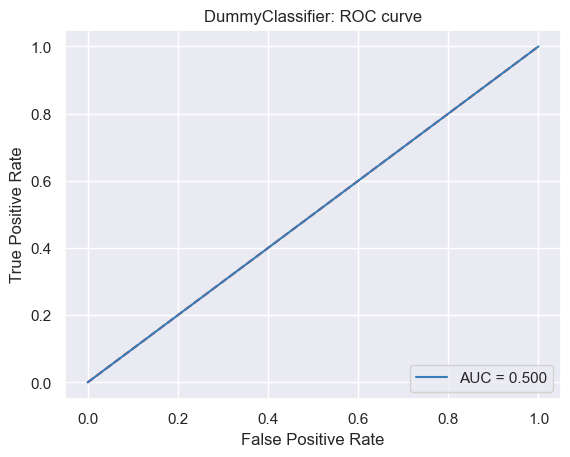

[DummyClassifier] Best threshold = 0.0025
[DummyClassifier] Best business score = 0.4667


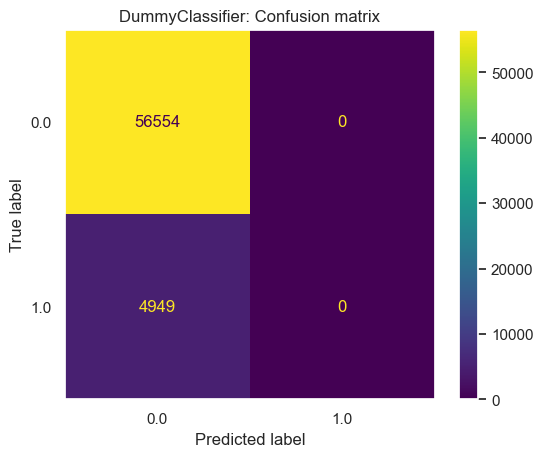

c:\Users\cosic\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\cosic\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\cosic\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,precision,recall,f1-score,support
0.0,0.919532,1.000000,0.958080,56554.000000
1.0,0.000000,0.000000,0.000000,4949.000000
accuracy,0.919532,0.919532,0.919532,0.919532
macro avg,0.459766,0.500000,0.479040,61503.000000
weighted avg,0.845540,0.919532,0.880985,61503.000000


2025/12/03 19:06:46 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/12/03 19:06:49 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'DummyClassifier' already exists. Creating a new version of this model...
2025/12/03 19:06:50 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: DummyClassifier, version 3
Created version '3' of model 'DummyClassifier'.


🏃 View run DummyClassifier at: http://localhost:5000/#/experiments/193419634280483624/runs/407a7253d1534d60a8cb7233241b63fe
🧪 View experiment at: http://localhost:5000/#/experiments/193419634280483624
MLflow run: 407a7253d1534d60a8cb7233241b63fe
Model URI : models:/m-7951f59d4b0841f0aba8a7513346bf28


In [117]:
dc = DummyClassifier(strategy='most_frequent', random_state=RANDOM_STATE)
dc_name = 'DummyClassifier'

# Fit model
dc.fit(train_full_set, train_full_labels)

# Compute results
dc_business_score, dc_auc, dc_report, dc_y_pred_proba, dc_best_thresh, dc_y_pred = compute_classification_results(dc, dc_name, val_full_set, val_full_labels)

# Save logs and model to mlflow
run_id, model_uri = log_mlflow(dc, 
           dc_name, 
           auc_score=dc_auc, 
           custom_score=dc_business_score,
           f1_score=dc_report.loc['weighted avg', 'f1-score'], 
           acc_score=accuracy_score(val_full_labels, dc_y_pred),
           y_pred_proba=dc_y_pred_proba,
           best_thresh=dc_best_thresh,
           y_pred=dc_y_pred,
           train_class_0=Counter(train_full_labels)[0],
           train_class_1=Counter(train_full_labels)[1],
           expected_features=EXPECTED,
           class_mapping={0: 'repaid', 1: 'not repaid'},
           registered_model_name="DummyClassifier",
           tracking_uri="http://localhost:5000/",
           experiment_name="Credit_Scoring_Project",
           X_sample=val_full_set)

print("MLflow run:", run_id)
print("Model URI :", model_uri)

## Log Baseline to MLFlow

In [118]:
log_mlflow(dc, 
           dc_name, 
           auc_score=dc_auc, 
           custom_score=dc_business_score,
           f1_score=dc_report.loc['weighted avg', 'f1-score'], 
           acc_score=accuracy_score(val_full_labels, dc_y_pred),
           y_pred_proba=dc_y_pred_proba,
           best_thresh=dc_best_thresh,
           y_pred=dc_y_pred,
           train_class_0=Counter(train_full_labels)[0],
           train_class_1=Counter(train_full_labels)[1])

2025/12/03 19:06:50 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/12/03 19:06:52 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run DummyClassifier at: http://localhost:5000/#/experiments/193419634280483624/runs/9a36d86dfbe8480f925cb8fe47eb5ccc
🧪 View experiment at: http://localhost:5000/#/experiments/193419634280483624


('9a36d86dfbe8480f925cb8fe47eb5ccc',
 'models:/m-df26d836aac1459bb781d834b0328aae')

## Regression Logistique

In [119]:
# Create logistic regression model
si = SimpleImputer(strategy='mean')
lr = LogisticRegression(random_state=RANDOM_STATE, class_weight='balanced', max_iter=1000)
lr_name = 'LogisticRegression'

pipe_lr = Pipeline([
    ('imputer', si),
    ('classifier', lr)
])

# Train model
pipe_lr.fit(train_full_set, train_full_labels)

c:\Users\cosic\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('imputer', SimpleImputer()),
                ('classifier',
                 LogisticRegression(class_weight='balanced', max_iter=1000,
                                    random_state=42))])

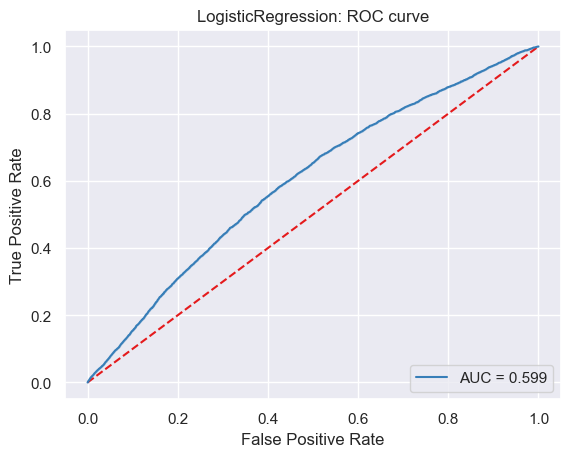

[LogisticRegression] Best threshold = 0.4897
[LogisticRegression] Best business score = 0.4196


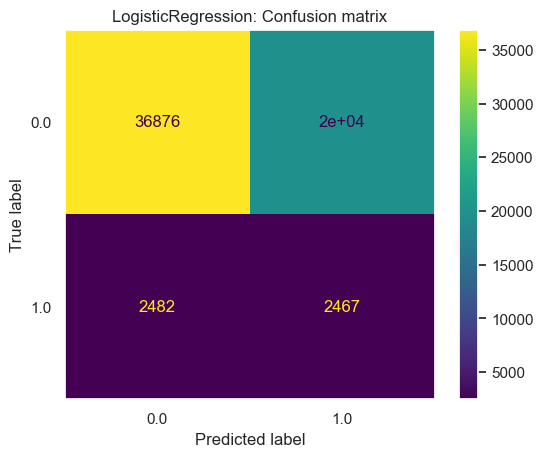

,precision,recall,f1-score,support
0.0,0.936938,0.652049,0.768955,56554.000000
1.0,0.111402,0.498485,0.182107,4949.000000
accuracy,0.639692,0.639692,0.639692,0.639692
macro avg,0.524170,0.575267,0.475531,61503.000000
weighted avg,0.870509,0.639692,0.721733,61503.000000


2025/12/03 20:31:16 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/12/03 20:31:22 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Successfully registered model 'LogisticRegression'.
2025/12/03 20:31:24 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LogisticRegression, version 1


🏃 View run LogisticRegression at: http://localhost:5000/#/experiments/193419634280483624/runs/c90d7ac324bc48fe8689f8ee76888b05
🧪 View experiment at: http://localhost:5000/#/experiments/193419634280483624
MLflow run: c90d7ac324bc48fe8689f8ee76888b05
Model URI : models:/m-6ef08720bec54b089d18d44c16788966


Created version '1' of model 'LogisticRegression'.


In [120]:
# Compute results
lr_business_score, lr_auc, lr_report, lr_y_pred_proba, lr_best_thresh, lr_y_pred = compute_classification_results(pipe_lr, lr_name, val_full_set, val_full_labels)

# Save logs and model to mlflow
run_id, model_uri = log_mlflow(pipe_lr, lr_name, 
           auc_score=lr_auc, 
           custom_score=lr_business_score,
           f1_score=lr_report.loc['weighted avg', 'f1-score'], 
           acc_score=lr_report.loc['accuracy', 'precision'],
           y_pred_proba=lr_y_pred_proba,
           best_thresh=lr_best_thresh,
           y_pred=lr_y_pred,
           train_class_0=Counter(train_full_labels)[0], 
           train_class_1=Counter(train_full_labels)[1],
           expected_features=EXPECTED,
           class_mapping={0: 'repaid', 1: 'not repaid'},
           registered_model_name="LogisticRegression",
           tracking_uri="http://localhost:5000/",
           experiment_name="Credit_Scoring_Project",
           X_sample=val_full_set)

print("MLflow run:", run_id)
print("Model URI :", model_uri)

## Log Regression Logistique to MLFlow

In [121]:
log_mlflow(pipe_lr, lr_name, 
           auc_score=lr_auc, 
           custom_score=lr_business_score,
           f1_score=lr_report.loc['weighted avg', 'f1-score'], 
           acc_score=lr_report.loc['accuracy', 'precision'],
           y_pred_proba=lr_y_pred_proba,
           best_thresh=lr_best_thresh,
           y_pred=lr_y_pred,
           train_class_0=Counter(train_full_labels)[0], 
           train_class_1=Counter(train_full_labels)[1])

2025/12/03 20:31:24 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/12/03 20:31:27 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run LogisticRegression at: http://localhost:5000/#/experiments/193419634280483624/runs/0b70d11d49e5439882703c015d9c0574
🧪 View experiment at: http://localhost:5000/#/experiments/193419634280483624


('0b70d11d49e5439882703c015d9c0574',
 'models:/m-a301309366674547a99920b8b340259a')

In [122]:
def scale_pos_weight(y):
    # ratio négatifs / positifs pour LGBM & XGB (utile en données déséquilibrées)
    pos = (y == 1).sum()
    neg = (y == 0).sum()
    return max(1.0, neg / max(1, pos))

## LGBM

[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.120625 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 61726
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 597
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080794 -> initscore=-2.431606
[LightGBM] [Info] Start training from score -2.431606


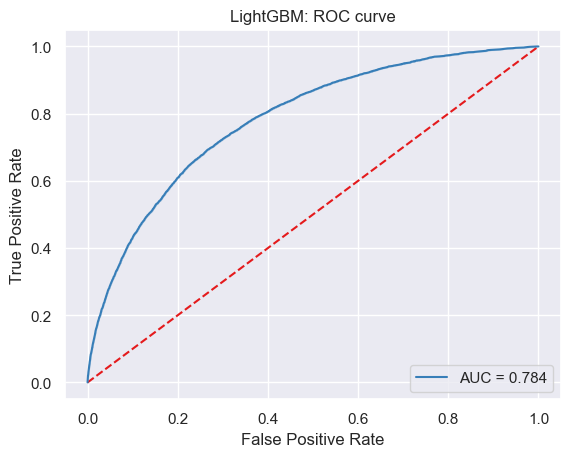

[LightGBM] Best threshold = 0.5400
[LightGBM] Best business score = 0.2850


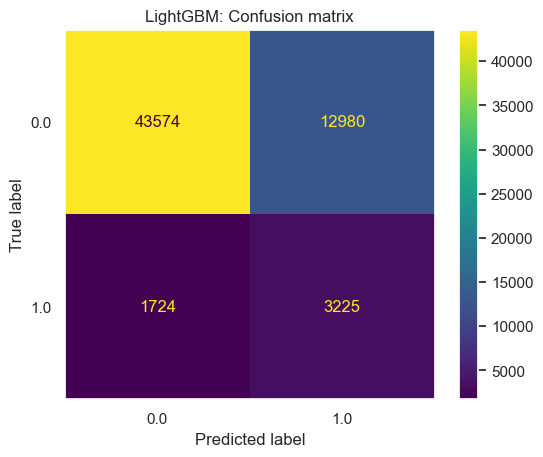

,precision,recall,f1-score,support
0.0,0.961941,0.770485,0.855634,56554.000000
1.0,0.199013,0.651647,0.304907,4949.000000
accuracy,0.760922,0.760922,0.760922,0.760922
macro avg,0.580477,0.711066,0.580270,61503.000000
weighted avg,0.900550,0.760922,0.811318,61503.000000


2025/12/03 21:56:15 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/12/03 21:56:29 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Successfully registered model 'LightGBM'.
2025/12/03 21:56:32 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LightGBM, version 1
Created version '1' of model 'LightGBM'.


🏃 View run LightGBM at: http://localhost:5000/#/experiments/193419634280483624/runs/0f57d2bbebd6464eae4ae13546c05b31
🧪 View experiment at: http://localhost:5000/#/experiments/193419634280483624
MLflow run: 0f57d2bbebd6464eae4ae13546c05b31
Model URI : models:/m-3d123ec77be94c82a8a51c4d9b440a59


In [123]:
# Create light gradient boosting model classifier
lgbm = LGBMClassifier(scale_pos_weight=scale_pos_weight(train_full_labels), random_state=RANDOM_STATE)
lgbm_name = 'LightGBM'

# Train model
lgbm.fit(train_full_set, train_full_labels)

# Compute results
lgbm_business_score, lgbm_auc, lgbm_report, lgbm_y_pred_proba, lgbm_best_thresh, lgbm_y_pred = compute_classification_results(lgbm, lgbm_name, val_full_set, val_full_labels)

# Save logs
lgbm_params = lgbm.get_params()
run_id, model_uri = log_mlflow(lgbm, 
           lgbm_name,
           custom_score=lgbm_business_score,
           auc_score=lgbm_auc,
           f1_score=lgbm_report.loc['weighted avg', 'f1-score'], 
           acc_score=lgbm_report.loc['accuracy', 'precision'],
           n_estimator=lgbm_params['n_estimators'],
           max_depth=lgbm_params['max_depth'],
           y_pred_proba=lgbm_y_pred_proba,
           best_thresh=lgbm_best_thresh,
           y_pred=lgbm_y_pred,
           train_class_0=Counter(train_full_labels)[0],
           train_class_1=Counter(train_full_labels)[1],
           expected_features=EXPECTED,
           class_mapping={0: 'repaid', 1: 'not repaid'},
           registered_model_name="LightGBM",
           tracking_uri="http://localhost:5000/",
           experiment_name="Credit_Scoring_Project",
           X_sample=val_full_set)

print("MLflow run:", run_id)
print("Model URI :", model_uri)

## Log LGBM to MLFlow

In [124]:
log_mlflow(lgbm, 
           lgbm_name,
           custom_score=lgbm_business_score,
           auc_score=lgbm_auc,
           f1_score=lgbm_report.loc['weighted avg', 'f1-score'], 
           acc_score=lgbm_report.loc['accuracy', 'precision'],
           n_estimator=lgbm_params['n_estimators'],
           max_depth=lgbm_params['max_depth'],
           y_pred_proba=lgbm_y_pred_proba,
           best_thresh=lgbm_best_thresh,
           y_pred=lgbm_y_pred,
           train_class_0=Counter(train_full_labels)[0],
           train_class_1=Counter(train_full_labels)[1])

2025/12/03 21:56:33 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/12/03 21:56:38 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run LightGBM at: http://localhost:5000/#/experiments/193419634280483624/runs/5d0fc4f23c79483ca86dcf9a1de32468
🧪 View experiment at: http://localhost:5000/#/experiments/193419634280483624


('5d0fc4f23c79483ca86dcf9a1de32468',
 'models:/m-76b0a300ad3d453db3e5260428b97f53')

## XGBoost

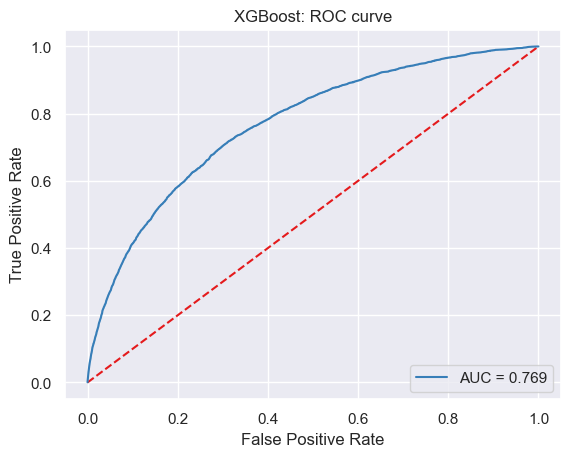

[XGBoost] Best threshold = 0.4378
[XGBoost] Best business score = 0.2973


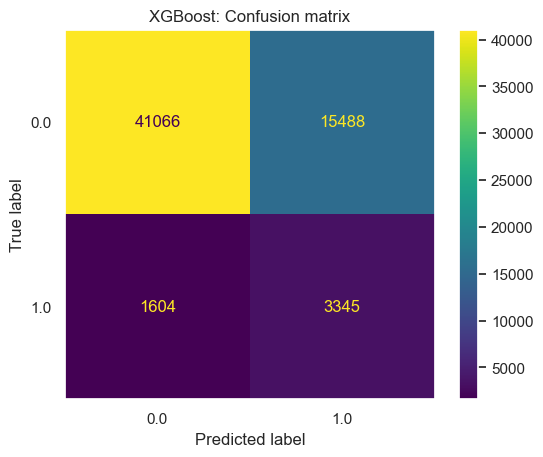

,precision,recall,f1-score,support
0.0,0.962409,0.726138,0.827743,56554.000000
1.0,0.177614,0.675894,0.281305,4949.000000
accuracy,0.722095,0.722095,0.722095,0.722095
macro avg,0.570011,0.701016,0.554524,61503.000000
weighted avg,0.899259,0.722095,0.783773,61503.000000


2025/12/03 23:25:11 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/12/03 23:25:15 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Successfully registered model 'XGBoost'.
2025/12/03 23:25:15 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: XGBoost, version 1
Created version '1' of model 'XGBoost'.


🏃 View run XGBoost at: http://localhost:5000/#/experiments/193419634280483624/runs/cb52c965f8c94b658a26a30cf1507b0d
🧪 View experiment at: http://localhost:5000/#/experiments/193419634280483624
MLflow run: cb52c965f8c94b658a26a30cf1507b0d
Model URI : models:/m-50330d9706474b1281fc6ba507cca8f3


In [125]:
# Create XGBoost classifier
xgbc = xgb.XGBClassifier(scale_pos_weight=scale_pos_weight(train_full_labels), random_state=RANDOM_STATE)
xgbc_name = 'XGBoost'

# Train model
xgbc.fit(train_full_set, train_full_labels)

# Compute results
xgbc_business_score, xgbc_auc, xgbc_report, xgbc_y_pred_proba, xgbc_best_thresh, xgbc_y_pred = compute_classification_results(xgbc, xgbc_name, val_full_set, val_full_labels)

# Save logs
xgbc_params = xgbc.get_params()
run_id, model_uri = log_mlflow(xgbc, xgbc_name,
           custom_score=xgbc_business_score,
           auc_score=xgbc_auc,
           f1_score=xgbc_report.loc['weighted avg', 'f1-score'], 
           acc_score=xgbc_report.loc['accuracy', 'precision'],
           n_estimator=xgbc_params['n_estimators'],
           max_depth=xgbc_params['max_depth'],
           y_pred_proba=xgbc_y_pred_proba,
           best_thresh=xgbc_best_thresh,
           y_pred=xgbc_y_pred,
           train_class_0=Counter(train_full_labels)[0],
           train_class_1=Counter(train_full_labels)[1],
           expected_features=EXPECTED,
           class_mapping={0: 'repaid', 1: 'not repaid'},
           registered_model_name="XGBoost",
           tracking_uri="http://localhost:5000/",
           experiment_name="Credit_Scoring_Project",
           X_sample=val_full_set)

print("MLflow run:", run_id)
print("Model URI :", model_uri)

## Log XGBoost to MLFlow 

In [126]:
log_mlflow(xgbc, xgbc_name,
           custom_score=xgbc_business_score,
           auc_score=xgbc_auc,
           f1_score=xgbc_report.loc['weighted avg', 'f1-score'], 
           acc_score=xgbc_report.loc['accuracy', 'precision'],
           n_estimator=xgbc_params['n_estimators'],
           max_depth=xgbc_params['max_depth'],
           y_pred_proba=xgbc_y_pred_proba,
           best_thresh=xgbc_best_thresh,
           y_pred=xgbc_y_pred,
           train_class_0=Counter(train_full_labels)[0],
           train_class_1=Counter(train_full_labels)[1])

2025/12/03 23:25:15 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/12/03 23:25:18 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run XGBoost at: http://localhost:5000/#/experiments/193419634280483624/runs/e73a2e2dc4e741e480e2356d27b83890
🧪 View experiment at: http://localhost:5000/#/experiments/193419634280483624


('e73a2e2dc4e741e480e2356d27b83890',
 'models:/m-f824714ad9ba455fbf1a44e040c6fe5e')

### Creer un tableau de comparaison

In [127]:
res_df = pd.DataFrame({
    'Model':['Dummy', 'LogisticRegression', 'LightGBM', 'XGBoost'],
    'Business score': [dc_business_score, lr_business_score, lgbm_business_score, xgbc_business_score],
    'Accuracy': [dc_report.loc['accuracy', 'precision'],
                 lr_report.loc['accuracy', 'precision'],
                 lgbm_report.loc['accuracy', 'precision'],
                 xgbc_report.loc['accuracy', 'precision']],
    'Precision': [dc_report.loc['macro avg', 'precision'],
                 lr_report.loc['macro avg', 'precision'],
                 lgbm_report.loc['macro avg', 'precision'],
                 xgbc_report.loc['macro avg', 'precision']],
    'Recall': [dc_report.loc['macro avg', 'recall'],
               lr_report.loc['macro avg', 'recall'],
               lgbm_report.loc['macro avg', 'recall'],
               xgbc_report.loc['macro avg', 'recall']],
    'F-1 score': [dc_report.loc['macro avg', 'f1-score'],
                  lr_report.loc['macro avg', 'f1-score'],
                  lgbm_report.loc['macro avg', 'f1-score'],
                  xgbc_report.loc['macro avg', 'f1-score']],
    'AUC score': [dc_auc, lr_auc, lgbm_auc, xgbc_auc],
    'Best threshold': [dc_best_thresh, lr_best_thresh, lgbm_best_thresh, xgbc_best_thresh],
    'Predicted probabilities': [dc_y_pred_proba, lr_y_pred_proba, lgbm_y_pred_proba, xgbc_y_pred_proba],
    'Predictions': [dc_y_pred, lr_y_pred, lgbm_y_pred, xgbc_y_pred]
})

display(res_df)

,Model,Business score,Accuracy,Precision,Recall,F-1 score,AUC score,Best threshold,Predicted probabilities,Predictions
0,Dummy,0.466693,0.919532,0.459766,0.500000,0.479040,0.500000,0.002500,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,LogisticRegression,0.419618,0.639692,0.524170,0.575267,0.475531,0.599467,0.489699,"[0.489378998572234, 0.3010807975437133, 0.5267...","[0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, ..."
2,LightGBM,0.284976,0.760922,0.580477,0.711066,0.580270,0.783834,0.539974,"[0.6535464655433384, 0.3616678688501471, 0.689...","[1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, ..."
3,XGBoost,0.297311,0.722095,0.570011,0.701016,0.554524,0.768818,0.437836,"[0.72991514, 0.2737059, 0.64394, 0.097455874, ...","[1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, ..."


#### Notre priorite est la minimisation du cout metier (busniess score) donc XGBoost est le meilleur modele et le meilleur F1.
#### En parallele LGBM est tres proche, meilleur AUC (capacite de classement global), et une precision plus forte (mmoins de FP)
#### Initialement j'opterais pour XGBoost, mais LGBM sera peut etre plus rapide. Il faudra donc modifier certains parametres.

In [128]:
import gc

## LGBM Hyperparameters Tuning

{'colsample_bytree': 0.901127042041473, 'learning_rate': 0.03437975286448596, 'max_depth': 7, 'min_child_samples': 40, 'n_estimators': 500, 'num_leaves': 40, 'reg_alpha': 0.001435079991825317, 'reg_lambda': 0.12777019506968337, 'subsample': 0.9735764296788622}
[LightGBM] [Info] Number of positive: 15901, number of negative: 180905
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.100070 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 61707                   
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 593
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080795 -> initscore=-2.431590
[LightGBM] [Info] Start training from score -2.431590
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGB

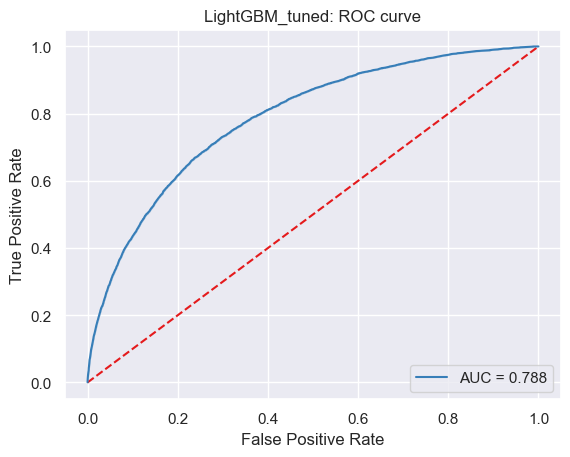

[LightGBM_tuned] Best threshold = 0.5032
[LightGBM_tuned] Best business score = 0.2813


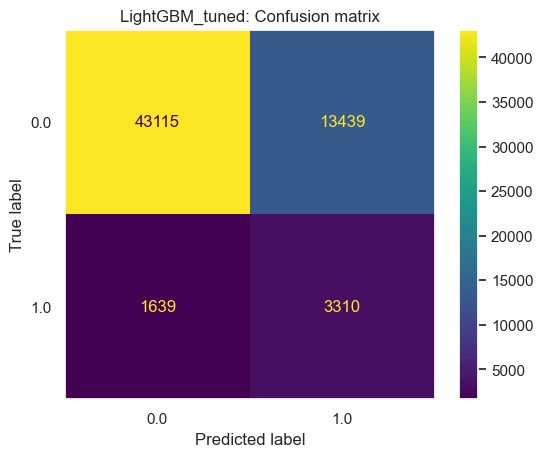

,precision,recall,f1-score,support
0.0,0.963378,0.762369,0.851167,56554.000000
1.0,0.197624,0.668822,0.305097,4949.000000
accuracy,0.754841,0.754841,0.754841,0.754841
macro avg,0.580501,0.715595,0.578132,61503.000000
weighted avg,0.901759,0.754841,0.807226,61503.000000


2025/12/04 01:13:26 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/12/04 01:13:30 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Successfully registered model 'LightGBM_Tuned'.
2025/12/04 01:13:30 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LightGBM_Tuned, version 1


🏃 View run LightGBM_tuned at: http://localhost:5000/#/experiments/193419634280483624/runs/4c971292ed8040dcb440001166711183
🧪 View experiment at: http://localhost:5000/#/experiments/193419634280483624
MLflow run: 4c971292ed8040dcb440001166711183
Model URI : models:/m-a95a24c03b954e6093e734657d00554c


Created version '1' of model 'LightGBM_Tuned'.


In [129]:
# Create LightGBM classifier for tuning
lgbmt = LGBMClassifier(scale_pos_weight=scale_pos_weight(train_full_labels), random_state=RANDOM_STATE)
lgbmt_name = 'LightGBM_tuned'

# Possible values of hyperparameters
lgbmt_space = {
    "n_estimators":      scope.int(hp.quniform("n_estimators", 400, 1500, 100)),
    "max_depth":         scope.int(hp.quniform("max_depth", 3, 12, 1)),
    "num_leaves":        scope.int(hp.quniform("num_leaves", 16, 128, 4)),
    "learning_rate":     hp.loguniform("learning_rate", np.log(0.005), np.log(0.2)),
    "subsample":         hp.uniform("subsample", 0.6, 1.0),
    "colsample_bytree":  hp.uniform("colsample_bytree", 0.6, 1.0),
    "min_child_samples": scope.int(hp.quniform("min_child_samples", 20, 200, 10)),
    "reg_alpha":         hp.loguniform("reg_alpha", np.log(1e-3), np.log(10.0)),
    "reg_lambda":        hp.loguniform("reg_lambda", np.log(1e-3), np.log(10.0))
}

# define objective function
def lgbmt_tuning(params):
    # Cast integer parameters to int
    params['n_estimators'] = int(params['n_estimators'])
    params['max_depth'] = int(params['max_depth'])
    params['num_leaves'] = int(params['num_leaves'])

    print(params)

    lgbmt.set_params(**params)
    score = cross_val_score(lgbmt, train_full_set, train_full_labels, scoring=business_score).mean()
    return {"loss": -score, "status": STATUS_OK, "model":lgbmt}

# Initialize trials object
lgbmt_trials = Trials()

# Find best model
lgbmt_best = fmin(fn=lgbmt_tuning, 
                space=lgbmt_space, 
                algo=tpe.suggest, max_evals=5, trials=lgbmt_trials)
lgbmt_best_model = trials_best_model(lgbmt_trials)
print(lgbmt_best_model)

# Train model
lgbmt_best_model.fit(train_full_set, train_full_labels)

# Compute results
lgbmt_business_score, lgbmt_auc, lgbmt_report, lgbmt_y_pred_proba, lgbmt_best_thresh, lgbmt_y_pred = compute_classification_results(lgbmt_best_model, lgbmt_name, val_full_set, val_full_labels)

# Save logs
lgbmt_params = lgbmt.get_params()
run_id, model_uri = log_mlflow(lgbmt_best_model, lgbmt_name,
           custom_score=lgbmt_business_score,
           auc_score=lgbmt_auc,
           f1_score=lgbmt_report.loc['weighted avg', 'f1-score'], 
           acc_score=lgbmt_report.loc['accuracy', 'precision'],
           n_estimator=lgbmt_params['n_estimators'],
           max_depth=lgbmt_params['max_depth'],
           y_pred_proba=lgbmt_y_pred_proba,
           best_thresh=lgbmt_best_thresh,
           y_pred=lgbmt_y_pred,
           train_class_0=Counter(train_full_labels)[0],
           train_class_1=Counter(train_full_labels)[1],
           expected_features=EXPECTED,
           class_mapping={0: 'repaid', 1: 'not repaid'},
           registered_model_name="LightGBM_Tuned",
           tracking_uri="http://localhost:5000/",
           experiment_name="Credit_Scoring_Project",
           X_sample=val_full_set)

print("MLflow run:", run_id)
print("Model URI :", model_uri)

## Log LGBM tunned to MLFlow

In [130]:
log_mlflow(lgbmt_best_model, lgbmt_name,
           custom_score=lgbmt_business_score,
           auc_score=lgbmt_auc,
           f1_score=lgbmt_report.loc['weighted avg', 'f1-score'], 
           acc_score=lgbmt_report.loc['accuracy', 'precision'],
           n_estimator=lgbmt_params['n_estimators'],
           max_depth=lgbmt_params['max_depth'],
           y_pred_proba=lgbmt_y_pred_proba,
           best_thresh=lgbmt_best_thresh,
           y_pred=lgbmt_y_pred,
           train_class_0=Counter(train_full_labels)[0],
           train_class_1=Counter(train_full_labels)[1])

2025/12/04 01:13:31 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/12/04 01:13:35 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run LightGBM_tuned at: http://localhost:5000/#/experiments/193419634280483624/runs/b3546bdbac9043db8acfef48f902e986
🧪 View experiment at: http://localhost:5000/#/experiments/193419634280483624


('b3546bdbac9043db8acfef48f902e986',
 'models:/m-69fab4c325654c1caf2496be78bb1b73')

## Features importance

In [131]:
#%pip install shap --upgrade

### Definition de parametres pour eviter de faire exploser la RAM

In [132]:
lgbmt_best_model

LGBMClassifier(colsample_bytree=0.7374329996624444,
               learning_rate=0.010827925986143055, max_depth=12,
               min_child_samples=70, n_estimators=900, num_leaves=72,
               random_state=42, reg_alpha=0.2978165310762666,
               reg_lambda=0.0029251083553819552,
               scale_pos_weight=11.377138257194607,
               subsample=0.9516034501190592)

In [133]:
model = lgbmt_best_model

In [134]:
X_train_use = train_full_set.copy()
X_test_use = val_full_set.copy()

BG_SIZE = 2000
EVAL_SIZE = 5000

In [135]:
# echantillons
X_bg = X_train_use.sample(min(BG_SIZE, len(X_train_use)), random_state=RANDOM_STATE)
X_eval = X_test_use.sample(min(EVAL_SIZE, len(X_test_use)), random_state=RANDOM_STATE)

In [136]:
X_bg.to_csv("../Sources/shap_background.csv", index=False)
X_eval.to_csv("../Sources/shap_evaluation.csv", index=False)

X_bg.to_parquet("artifacts/shap_background.parquet", index=False)
X_eval.to_parquet("artifacts/shap_evaluation.parquet", index=False)

In [137]:
# alleger la memoire
for df in (X_bg, X_eval):
    num_cols = df.select_dtypes(include=[np.number]).columns
    df[num_cols] = df[num_cols].astype(np.float32)

In [138]:
# Explainer shap pour LGBM
explainer = shap.TreeExplainer(model, model_output='raw', feature_perturbation="tree_path_dependent")

In [139]:
# calcul des valeurs shap
exp = explainer(X_eval)

## Visuels pratiques

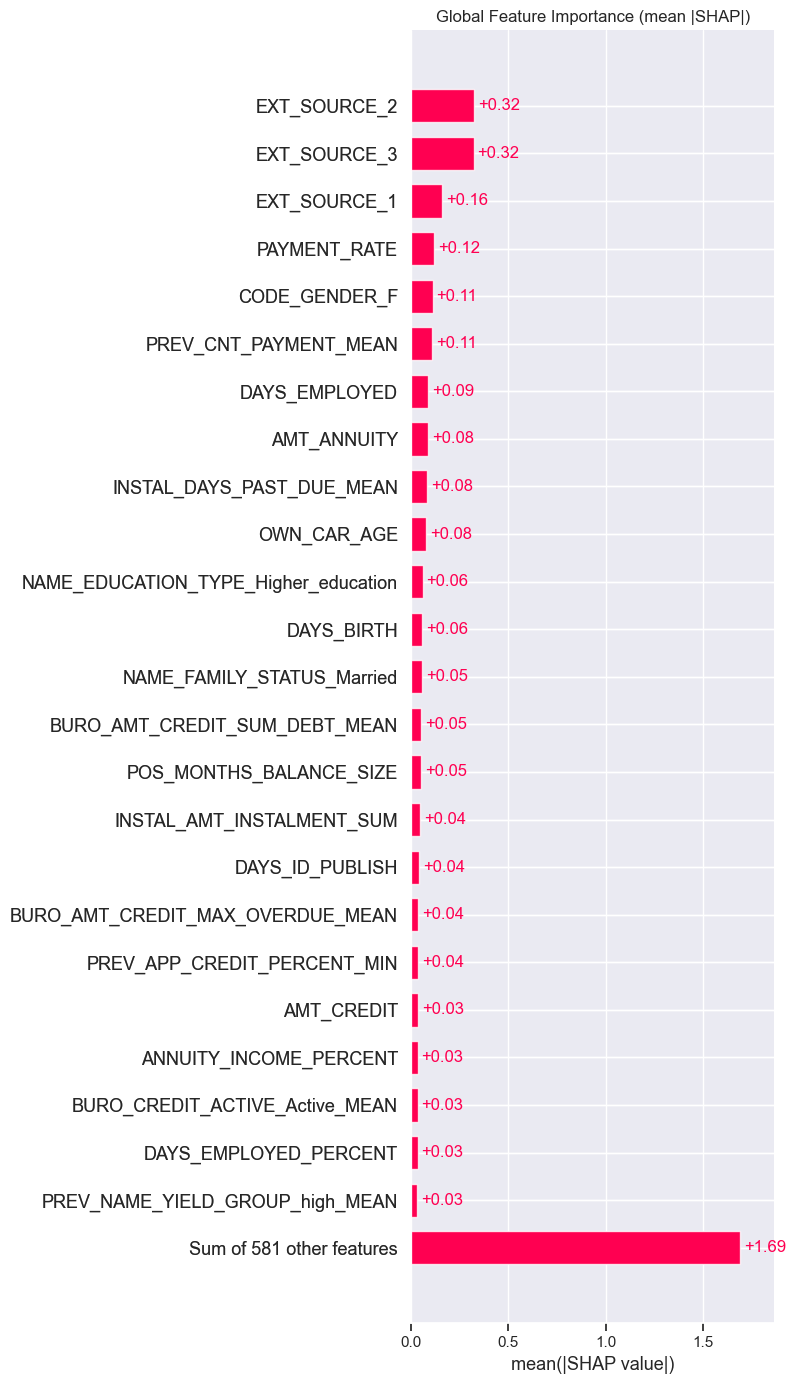

In [140]:
# importance moyenne absolue des features (|SHAP|)
plt.figure(figsize=(9,6))
shap.plots.bar(exp, max_display=25, show=False)
plt.title("Global Feature Importance (mean |SHAP|)")
plt.tight_layout() 
plt.show()

#### Le modèle s’appuie principalement sur les scores externes (EXT_SOURCE 1.2.3) + quelques variables (DAYS_EMPLOYED, CODE_GENDER_F, PAYMENT_RATE) socio-éco fortes

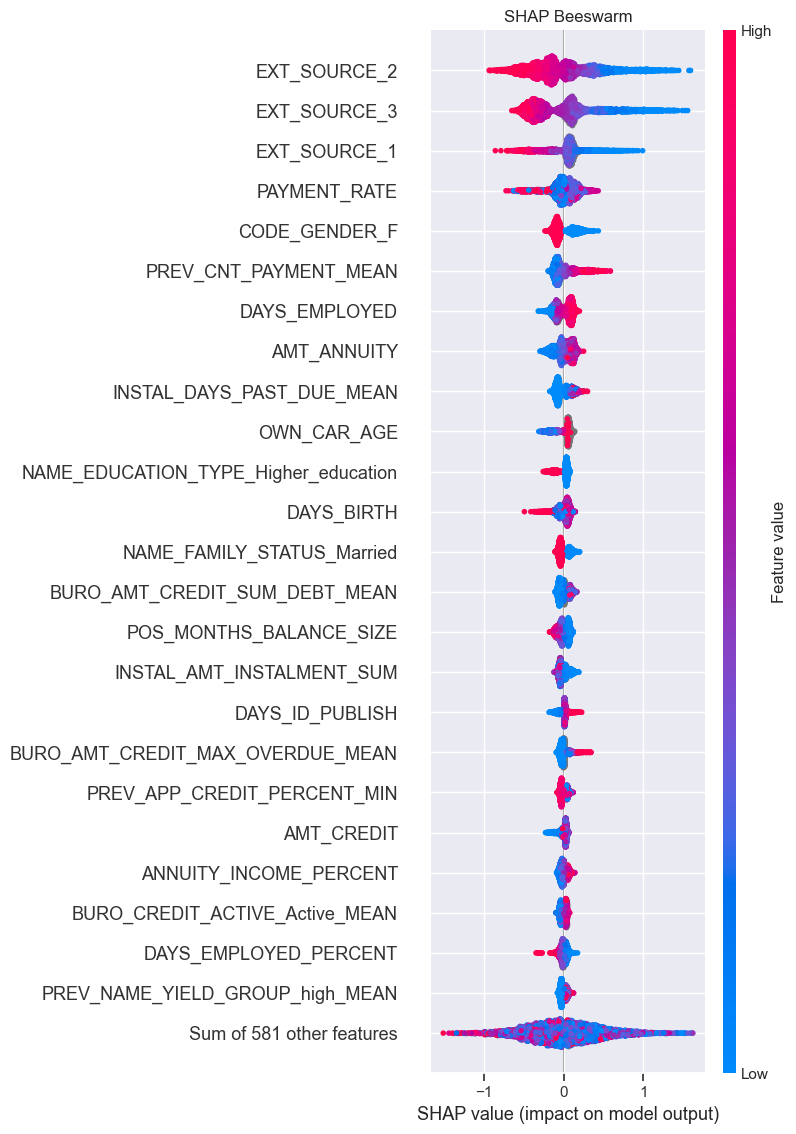

In [141]:
# beeswarm (impact global + direction)
plt.figure(figsize=(9,6))
shap.plots.beeswarm(exp, max_display=25, show=False)
plt.title("SHAP Beeswarm")
plt.tight_layout()
plt.show()

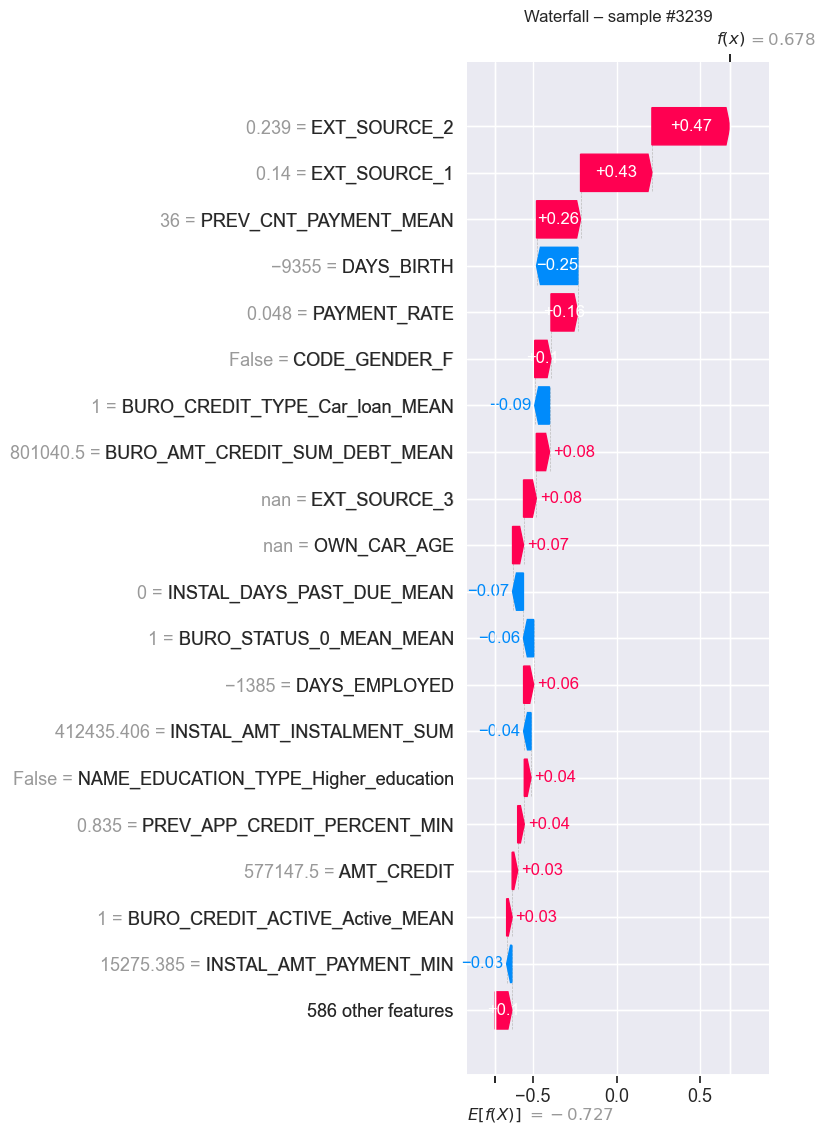

In [142]:
# waterfall (explication locale d’un individu au hasard)
ROW_IDX = random.randint(0, len(exp) - 1)
plt.figure(figsize=(9,6))
shap.plots.waterfall(exp[ROW_IDX], max_display=20, show=False)
plt.title(f"Waterfall – sample #{ROW_IDX}")
plt.tight_layout()
plt.show()

## Sauvegarde meilleur modele + seuil + meta

In [143]:
model

LGBMClassifier(colsample_bytree=0.7374329996624444,
               learning_rate=0.010827925986143055, max_depth=12,
               min_child_samples=70, n_estimators=900, num_leaves=72,
               random_state=42, reg_alpha=0.2978165310762666,
               reg_lambda=0.0029251083553819552,
               scale_pos_weight=11.377138257194607,
               subsample=0.9516034501190592)

In [144]:
BEST_MODEL = model
BEST_THR  = float(lgbmt_best_thresh)
FEATURES  = list(train_full_set.columns)

In [145]:
ART_DIR = Path.cwd() / "artifacts"
ART_DIR.mkdir(parents=True, exist_ok=True)

In [146]:
# chemins de sauvegarde
MODEL_PATH = ART_DIR / "model.joblib"
META_PATH  = ART_DIR / "artifacts.json"

In [147]:
joblib.dump(BEST_MODEL, MODEL_PATH)

['c:\\Users\\cosic\\Documents\\GitHub\\OC_DataScientist_P7\\Projet_7\\Script\\artifacts\\model.joblib']

In [148]:
artifacts = {
    "model_version": "v1",
    "saved_at": datetime.datetime.utcnow().isoformat() + "Z",
    "threshold": BEST_THR,
    "expected_features": FEATURES,
    "class_mapping": {"Accepter": 0, "Refuser": 1},
    "notes": "LGBM cost-optimized"
}

with open(META_PATH, "w", encoding="utf-8") as f:
    json.dump(artifacts, f, indent=4, ensure_ascii=False)